# Value + Momentum Factor Portfolio

#### *KOSPI. 직전 분기 시가총액 기준 상위 200위 대상으로 분기별로 종목 유니버스 구성.
#### *리서치 페이퍼와는 다르게 PER을 밸류 팩터로 선정. 모멘텀 팩터는 중장기 모멘텀(120일) 사용. 
#### *Integrated 방식에서 Z-score는 $Z = Z_{MOM} - Z_{PER}$를 기준으로 사용.

## Import Modules

In [1]:
import FinanceDataReader as fdr

from pykrx import stock

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pytimekr import pytimekr
import datetime
from datetime import timedelta

import time
import pickle

## Load Datasets

In [314]:
stock_data = pd.read_pickle('C:/Users/kim56/anaconda3/Find-A/quant/Data/kospi200_z_data.p')
stock_data

,티커,종목명,날짜,시가,고가,저가,종가,거래량,등락률,ABS_MOM,BPS,PER,PBR,시가총액,Z_MOM,Z_PER
1872,006840,AK홀딩스,2003-03-31,6980.0,7011.0,6729.0,6731.0,2960.0,-3.581149,-3.080381,34409.0,7.11,0.31,6.450000e+10,-0.155024,-0.076816
1873,006840,AK홀딩스,2003-04-01,6824.0,6824.0,6635.0,6668.0,2400.0,-0.935968,-0.428292,34409.0,7.11,0.31,6.450000e+10,-0.401335,-0.076816
1874,006840,AK홀딩스,2003-04-02,6636.0,6855.0,6636.0,6856.0,5670.0,2.819436,3.275126,34409.0,7.11,0.31,6.450000e+10,0.589797,-0.076816
1875,006840,AK홀딩스,2003-04-03,7074.0,7106.0,6980.0,7106.0,9820.0,3.646441,4.039021,34409.0,7.11,0.31,6.450000e+10,1.094872,-0.076816
1876,006840,AK홀딩스,2003-04-04,7106.0,7324.0,6887.0,7169.0,6240.0,0.886575,1.259774,34409.0,7.11,0.31,6.450000e+10,-0.153911,-0.076816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752955,081660,휠라홀딩스,2022-12-23,34100.0,35000.0,33900.0,34450.0,360537.0,1.472754,1.464576,26806.0,8.44,1.23,2.007861e+12,2.051878,-0.349480
3752956,081660,휠라홀딩스,2022-12-26,34450.0,34600.0,34000.0,34500.0,138323.0,0.145138,0.132558,26806.0,8.44,1.23,2.007861e+12,-0.116239,-0.349480
3752957,081660,휠라홀딩스,2022-12-27,34500.0,35000.0,34300.0,34950.0,316271.0,1.304348,1.273898,26806.0,8.44,1.23,2.007861e+12,0.133604,-0.349480
3752958,081660,휠라홀딩스,2022-12-28,34050.0,34250.0,33500.0,33550.0,180426.0,-4.005722,-4.021987,26806.0,8.44,1.23,2.007861e+12,-0.709776,-0.349480


In [315]:
refer_data = pd.read_pickle('C:/Users/kim56/anaconda3/Find-A/quant/Data/refer_tickers.p')
refer_data

,티커,종목명,날짜,시가,고가,저가,종가,거래량,등락률,ABS_MOM,BPS,PER,PBR,시가총액
1811,006840,AK홀딩스,2003-01-02,9171.0,9358.0,8983.0,9079.0,13900.0,-3.332624,0.000000,NaN,NaN,NaN,NaN
1812,006840,AK홀딩스,2003-01-03,9265.0,9328.0,9045.0,9173.0,19750.0,1.035356,2.183990,NaN,NaN,NaN,NaN
1813,006840,AK홀딩스,2003-01-06,9265.0,9265.0,9108.0,9173.0,8550.0,0.000000,0.765756,NaN,NaN,NaN,NaN
1814,006840,AK홀딩스,2003-01-07,9202.0,9328.0,8921.0,9048.0,26260.0,-1.362695,-0.447704,NaN,NaN,NaN,NaN
1815,006840,AK홀딩스,2003-01-08,9140.0,9265.0,8952.0,9016.0,17500.0,-0.353669,0.449057,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3770469,000540,흥국화재,2022-12-23,3220.0,3235.0,3165.0,3205.0,43874.0,-0.620155,-0.575071,10599.0,3.63,0.30,2.033280e+11
3770470,000540,흥국화재,2022-12-26,3210.0,3220.0,3180.0,3200.0,18166.0,-0.156006,-0.114041,10599.0,3.63,0.30,2.033280e+11
3770471,000540,흥국화재,2022-12-27,3175.0,3240.0,3160.0,3230.0,14026072.0,0.937500,0.968196,10599.0,3.63,0.30,2.033280e+11
3770472,000540,흥국화재,2022-12-28,3230.0,3355.0,3195.0,3295.0,87016.0,2.012384,2.034545,10599.0,3.63,0.30,2.033280e+11


In [316]:
kospi = fdr.DataReader('KS11', '2003').reset_index()
benchmark_data = kospi[kospi['Date'].isin(dt)][['Date', 'Close']].reset_index(drop = True)
benchmark_data['Returns'] = benchmark_data['Close'] / benchmark_data['Close'][0] * 100

benchmark_data.columns = ['날짜', '종가', 'Returns']
benchmark_data

,날짜,종가,Returns
0,2003-03-31,535.700012,100.000000
1,2003-07-02,685.799988,128.019409
2,2003-10-07,727.090027,135.727088
3,2004-01-07,827.070007,154.390515
4,2004-04-12,918.859985,171.525101
...,...,...,...
72,2021-11-04,2983.219971,556.882566
73,2022-02-07,2745.060059,512.424864
74,2022-05-10,2596.560059,484.704126
75,2022-08-09,2503.459961,467.324978


## Portfolio

In [317]:
class Transaction() : 
    """
    로그 기록을 위해 Transaction object 생성.
    """
    
    def __init__(self, ticker, name, date, style, strategy, typ, price, count) :
        self.ticker = ticker
        self.name = name
        self.date = date
        self.style = style
        self.strategy = strategy
        self.typ = typ
        self.price = price
        self.count = count

        

class Portfolio() : 
    """
    Portfolio backtesting을 위한 object 생성.
    """
    
    def __init__(self, rebalancing_month = 3, style = 'Momentum', strategy = 'long', value_weight = None, momentum_weight = None,init_money = 10000, quantile = 0.2) : 
        """
        리밸런싱 주기, 스타일 팩터(momentum/value/MIxed/integrated), 사용할 전략(long/short/mix), 초기자본, 팩터 분위수 등의
        포트폴리오 세팅을 설정.
        """
        self.stock_data = None
        self.history = None
        self.dt = None
        self.transactions = None
        self.rebalancing_month = rebalancing_month
        self.rebalancing = rebalancing_month * 21
        self.strategy = strategy
        self.init_money = init_money
        self.money = init_money
        self.quantile = quantile
        self.style = style
        self.refer_data = None
        self.benchmark = None
        self.value_weight = value_weight
        self.momentum_weight = momentum_weight
        self.results = None
        
        if self.style == 'Momentum' : 
            self.value_weight = 0
            self.momentum_weight = 1
        elif self.style == 'Value' : 
            self.value_weight = 1
            self.momentum_weight = 0
        elif self.style == 'Mixed' : 
            if not self.value_weight : 
                print('Set the value weight of this portfolio.')
            if not self.momentum_weight : 
                print('Set the momentum weight of this portfolio.')
    
    def load_data(self, stock_data) : 
        """
        종목 유니버스의 일별 주가 데이터 적재.
        """
        print('The stock data is loaded.')
        self.stock_data = stock_data
        self.dt= np.sort(stock_data['날짜'].unique())[::self.rebalancing]
        mom_data = self.stock_data['ABS_MOM'] 
        val_data = self.stock_data['PER']

        Z_mom = (mom_data - mom_data.mean()) / mom_data.std()
        Z_val = (val_data - val_data.mean()) / val_data.std()

        Z = Z_mom - Z_val
        self.stock_data['Zscore'] = Z
        
    def load_refer_data(self, refer_data) : 
        print('The reference data is loaded.')
        self.refer_data = refer_data
    
    def load_benchmark(self, benchmark) : 
        """
        포트폴리오와 비교할 벤치마크(ex. 코스피지수)의 일별 데이터 적재"""
        print('The benchmark data is loaded.')
        self.benchmark = benchmark
        
    def set_config(self, rebalancing_month, style , strategy , value_weight , momentum_weight ,init_money , quantile ) : 
        self.rebalancing_month = rebalancing_month
        self.rebalancing = rebalancing_month * 21
        self.strategy = strategy
        self.money = init_money
        self.quantile = quantile
        self.style = style
        self.value_weight = value_weight
        self.momentum_weight = momentum_weight
        
        print(self.get_config())
        
    def get_config(self) : 
        return {
            'rebalancing_month' : self.rebalancing_month, 
            'style' : self.style, 
            'strategy' : self.strategy, 
            'value_weight' : self.value_weight, 
            'momentum_weight' : self.momentum_weight, 
            'init_money' : self.init_money, 
            'quantile' : self.quantile
        }

        
    def backtest(self, initialize = True) :
        """
        포트폴리오 설정값을 바탕으로 백테스팅 실행.
        """
        
        if initialize : 
            self.history = []
            self.transactions = []

#         if self.strategy == 'mix' : 
#             self.__backtest_mix(self.rebalancing, self.money, self.quantile, self.style)
        
        if self.strategy == 'long' : 
            self.__backtest_long(self.rebalancing, self.money, self.quantile, self.style)
    
    
    
    def __set_base(self, temp, style, strategy, quantile) : 
        if style == 'Momentum' : 
            base = 'ABS_MOM'
            if strategy == 'long' : 
                q_long_mom = temp[base].quantile(q = 1-quantile)
                return base, q_long_mom
            elif strategy == 'mix' : 
                q_long_mom = temp[base].quantile(q = 1-quantile)
                q_short_mom = temp[base].quantile(q = quantile)
                return base, (q_long_mom, q_short_mom)
        if style == 'Value' : 
            base = 'PER'
            if strategy == 'long' : 
                q_long_val = temp[base].quantile(q = quantile)
                return base, q_long_val
            elif strategy == 'mix' : 
                q_short_val = temp[base].quantile(q = 1-quantile)
                q_long_val = temp[base].quantile(q = quantile)
                return base, (q_long_val, q_short_val)
            
        if style == 'Mixed' : 
            base = ['ABS_MOM', 'PER']
            if strategy == 'long' : 
                q_long_mom = temp[base[0]].quantile(q = 1-quantile)
                q_long_val = temp[base[1]].quantile(q = quantile)
                return base, (q_long_mom, q_long_val)
            elif strategy == 'mix' : 
                q_long_mom = temp[base[0]].quantile(q = 1-quantile)
                q_short_mom = temp[base[0]].quantile(q = quantile)
                q_short_val = temp[base[1]].quantile(q = 1-quantile)
                q_long_val = temp[base[1]].quantile(q = quantile)
                return base, (q_long_mom, q_short_mom, q_long_val, q_short_val)
        if style == 'Integrated' : 
            base = 'Zscore'
            if strategy == 'long' : 
                q_long_z = temp[base].quantile(q= 1-quantile)
                return base, q_long_z


    def __backtest_long(self, rebalancing, init_money, quantile, style) : 

            
        if self.refer_data is not None:
            refer_data = self.refer_data
        else : 
            refer_data = self.stock_data
            
        money = init_money
        dt = np.sort(self.stock_data['날짜'].unique())
        long_mom = pd.DataFrame()
        long_val = pd.DataFrame()
        long_z = pd.DataFrame()

        for i, date in enumerate(dt[::rebalancing]) : 
            start = time.time()
            print(f"\tBalancing Accounts ... ({pd.to_datetime(date).strftime('%Y-%m-%d')})")
            #Rebalancing - Momentum 
            if len(long_mom) > 0  : 
                temp_long_mom = refer_data[(refer_data['티커'].isin(long_mom['티커'])) & (refer_data['날짜'] == date)]
                money += sum(temp_long_mom['종가'].to_numpy()* np.array(long_mom_count))
                
                for j in np.arange(len(long_mom_count)) : 
                    ticker = temp_long_mom.iloc[j,0]
                    name = temp_long_mom.iloc[j,1]
                    price = temp_long_mom.iloc[j, 6]
                    count = long_mom_count[j]
                    args = {'ticker' : ticker, 'name' : name, 'date': date, 'style' : 'Momentum', 'strategy' : 'long', 'typ':1, 'price' : price, 'count' : count}
                    trans = Transaction(**args)
                    self.transactions.append(trans)
                    
            #Rebalancing - Value
            if len(long_val) > 0 : 
                temp_long_val = refer_data[(refer_data['티커'].isin(long_val['티커'])) & (refer_data['날짜'] == date)]
                money += sum(temp_long_val['종가'].to_numpy()* np.array(long_val_count))
                
                for j in np.arange(len(long_val_count)) : 
                    ticker = temp_long_val.iloc[j,0]
                    name = temp_long_val.iloc[j,1]
                    price = temp_long_val.iloc[j, 6]
                    count = long_val_count[j]
                    args = {'ticker' : ticker, 'name' : name, 'date': date, 'style' : 'Value', 'strategy' : 'long', 'typ':1, 'price' : price, 'count' : count}
                    trans = Transaction(**args)
                    self.transactions.append(trans)
                    
            if len(long_z) > 0 : 
                temp_long_z = refer_data[(refer_data['티커'].isin(long_z['티커'])) & (refer_data['날짜'] == date)]
                money += sum(temp_long_z['종가'].to_numpy()* np.array(long_z_count))
                
                for j in np.arange(len(long_z_count)) : 
                    ticker = temp_long_z.iloc[j,0]
                    name = temp_long_z.iloc[j,1]
                    price = temp_long_z.iloc[j, 6]
                    count = long_z_count[j]
                    args = {'ticker' : ticker, 'name' : name, 'date': date, 'style' : 'Integrated', 'strategy' : 'long', 'typ':1, 'price' : price, 'count' : count}
                    trans = Transaction(**args)
                    self.transactions.append(trans)
                    
            self.history.append(money)
            long_mom_count = []
            long_val_count = []
            long_z_count = []
            current_money = money

            print(f"[{i+1}/{len(dt[::rebalancing])}] Constructing Portfolios ... ({pd.to_datetime(date).strftime('%Y-%m-%d')}))")
            #Buy or Sell
            temp =self.stock_data[self.stock_data['날짜'] == date]
            
            if style == 'Momentum' : 
                base, q_long = self.__set_base(temp, style, self.strategy, quantile)
                long_mom = temp[(temp[base] >= q_long)&(temp[base] > 0)]
                long_val = pd.DataFrame()
            elif style == 'Value' : 
                base, q_long = self.__set_base(temp, style, self.strategy, quantile)
                long_val = temp[temp[base] <= q_long]
                long_mom = pd.DataFrame()
            elif style == 'Mixed' : 
                base, (q_long_mom, q_long_val) = self.__set_base(temp, style, self.strategy, quantile)
                mom = base[0]
                per = base[1]
                long_mom = temp[temp[mom] >= q_long_mom]
                long_val = temp[temp[per] <= q_long_val]
            elif style == 'Integrated' : 
                base, q_long_z = self.__set_base(temp, style, self.strategy, quantile)
                long_z = temp[temp[base] >= q_long_z]
                

                
            
            #long pos. 모멘텀 팩터 동일 가중 포트폴리오 구성. 
            #long pos
            for stock in long_mom.itertuples() : 
                ticker = stock[1]
                name = stock[2]
                price = stock[7]
                weight = current_money / len(long_mom) * self.momentum_weight
                money -= weight 
                count = 1/price * weight
                args = {'ticker' : ticker, 'name' : name, 'date': date, 'style' : 'Momentum','strategy' : 'long', 'typ':0, 'price' : price, 'count' : count}
                trans = Transaction(**args)
                if i == len(dt[::rebalancing]) - 1 : 
                    break
                if ticker not in refer_data[refer_data['날짜'] == dt[rebalancing::rebalancing][i]]['티커'].to_numpy() : 
                    print(f'[{ticker}] is in bankruptcy')

                else :                                          
                    long_mom_count.append(count)
                    self.transactions.append(trans)
            #long pos. 밸류 팩터 동일 가중 포트폴리오 구성. 
            #long pos
            for stock in long_val.itertuples() : 
                ticker = stock[1]
                name = stock[2]
                price = stock[7]
                weight = current_money / len(long_val) * self.value_weight
                money -= weight 
                count = 1/price * weight
                args = {'ticker' : ticker, 'name' : name, 'date': date, 'style' : 'Value', 'strategy' : 'long', 'typ':0, 'price' : price, 'count' : count}
                trans = Transaction(**args)
                if i == len(dt[::rebalancing]) - 1 : 
                    break
                if ticker not in refer_data[refer_data['날짜'] == dt[rebalancing::rebalancing][i]]['티커'].to_numpy() : 
                    print(f'[{ticker}] is in bankruptcy')

                else :   
                    long_val_count.append(count)
                    self.transactions.append(trans)
            #long pos. Integrated 포트폴리오 구성. 
            #long pos
            for stock in long_z.itertuples() : 
                ticker = stock[1]
                name = stock[2]
                price = stock[7]
                weight = current_money / len(long_z)
                money -= weight 
                count = 1/price * weight
                args = {'ticker' : ticker, 'name' : name, 'date': date, 'style' : 'Integrated', 'strategy' : 'long', 'typ':0, 'price' : price, 'count' : count}
                trans = Transaction(**args)
                if i == len(dt[::rebalancing]) - 1 : 
                    break
                if ticker not in refer_data[refer_data['날짜'] == dt[rebalancing::rebalancing][i]]['티커'].to_numpy() : 
                    print(f'[{ticker}] is in bankruptcy')

                else :   
                    long_z_count.append(count)
                    self.transactions.append(trans)
                    
            end = time.time()
            print(self.history[-5:])
            print(f'{end - start : .3f} sec')
        results = pd.DataFrame({'Date' : dt[::rebalancing], 'Balance':self.history, 'Returns' : np.array(self.history)/self.init_money * 100})
        self.results = results
        
        
        
        plt.figure(figsize=(10, 5))

        plt.subplot(121) 
        plt.plot(results.Date, results.Balance)
        plt.title('Long Only Portfolio - Balance(\)')

        plt.subplot(122) 
        plt.plot(results.Date, results['Returns'])
        plt.title('Long Only Portfolio - Returns(%)')
    
         
            
            
#     def __backtest_mix(self, rebalancing, init_money, quantile, style) : 
#         if self.refer_data is not None:
#             refer_data = self.refer_data
#         else : 
#             refer_data = self.stock_data
            
#         money = init_money
#         dt = np.sort(self.stock_data['날짜'].unique())
#         long = None
#         short = None
#         for i, date in enumerate(dt[::rebalancing]) : 
#             start = time.time()
#             #Rebalancing
#             if long is not None : 
#                 print(f"\tBalancing Accounts ... ({pd.to_datetime(date).strftime('%Y-%m-%d')})")
#                 temp_long = refer_data[(refer_data['티커'].isin(long['티커'])) & (refer_data['날짜'] == date)]
#                 temp_short = refer_data[(refer_data['티커'].isin(short['티커'])) & (refer_data['날짜'] == date)]
#                 money += sum(temp_long['종가'].to_numpy()* np.array(long_count))
#                 money -= sum(temp_short['종가'].to_numpy() * np.array(short_count))
                
#                 for j in np.arange(len(long_count)) : 
#                     ticker = temp_long.iloc[j,0]
#                     name = temp_long.iloc[j,1]
#                     price = temp_long.iloc[j, 6]
#                     count = long_count[j]
#                     args = {'ticker' : ticker, 'name' : name, 'date': date, 'strategy' : 'long', 'typ':1, 'price' : price, 'count' : count}
#                     trans = Transaction(**args)
#                     self.transactions.append(trans)
#                 for j in np.arange(len(short_count)) : 
#                     ticker = temp_short.iloc[j,0]
#                     name = temp_short.iloc[j,1]
#                     price = temp_short.iloc[j, 6]
#                     count = short_count[j]
#                     args = {'ticker' : ticker, 'name' : name, 'date': date, 'strategy' : 'short', 'typ':1, 'price' : price, 'count' : count}
#                     trans = Transaction(**args)
#                     self.transactions.append(trans) 
                    
#             self.history.append(money)
#             long_count = []
#             short_count = []

#             print(f"[{i+1}/{len(dt[::rebalancing])}] Constructing Portfolios ... ({pd.to_datetime(date).strftime('%Y-%m-%d')}))")
#             #Buy or Sell
#             temp =self.stock_data[self.stock_data['날짜'] == date]
#             base, (q_long, q_short) = self.__set_base(temp, style, self.strategy, quantile)
#             if style == 'Momentum' : 
#                 long = temp[(temp[base] >= q_long)&(temp[base] > 0)]
#                 short = temp[(temp[base] <= q_short)&(temp[base] < 0)]
#             elif style == 'Value' : 
#                 long = temp[temp[base] <= q_long]
#                 short = temp[temp[base] >= q_short]
#             #long/short에 대해 100원어치의 주식만 buy/sell
#             #long pos
#             for stock in long.itertuples() : 
#                 ticker = stock[1]
#                 name = stock[2]
#                 price = stock[7]
#                 weight = money / len(long)
#                 money -= weight
#                 count = 1/price * weight
#                 args = {'ticker' : ticker, 'name' : name, 'date': date, 'strategy' : 'long', 'typ':0, 'price' : price, 'count' : count}
#                 trans = Transaction(**args)
#                 if i == len(dt[::rebalancing]) - 1 : 
#                     break
#                 if ticker not in refer_data[(refer_data['티커'].isin(refer_data['티커'])) & (refer_data['날짜'] == dt[rebalancing::rebalancing][i])]['티커'].to_numpy() : 
#                     print(f'[{ticker}] is in bankruptcy')

#                 else :                                          
#                     long_count.append(count)
#                     self.transactions.append(trans)
#             #short pos
#             for stock in short.itertuples() : 
#                 ticker = stock[1]
#                 name = stock[2]
#                 price = stock[7]
#                 weight = money / len(short)
#                 money += weight
#                 count = 1/price * weight
#                 args = {'ticker' : ticker, 'name' : name, 'date': date, 'strategy' : 'short', 'typ':0, 'price' : price, 'count' : count}
#                 trans = Transaction(**args)
#                 if i == len(dt[::rebalancing]) - 1 : 
#                     break
                    
#                 if ticker not in refer_data[(refer_data['티커'].isin(refer_data['티커'])) & (refer_data['날짜'] == dt[rebalancing::rebalancing][i])]['티커'].to_numpy() : 
#                     print(f'[{ticker}] is in bankruptcy')
# #                 if ticker not in self.stock_data[self.stock_data['날짜'] == dt[rebalancing::rebalancing][i]]['티커'].to_numpy() : 
# #                     print(f'[{ticker}] in bankruptcy')

#                 else : 
#                     short_count.append(count)
#                     self.transactions.append(trans)
                    
#             end = time.time()
#             print(self.history[-5:])
#             print(f'{end - start : .3f} sec')
#         results = pd.DataFrame({'Date' : dt[::rebalancing], 'Balance':self.history, 'Returns(%)' : np.array(self.history)/100})
#         self.results = results
        
#         plt.figure(figsize=(10, 5))

#         plt.subplot(121) 
#         plt.plot(results.Date, results.Balance)
#         plt.title('10% Long/Short Portfolio - Balance(\)')

#         plt.subplot(122) 
#         plt.plot(results.Date, results['Returns(%)'])
#         plt.title('10% Long/Short Portfolio - Returns(%)')
            
    def find_logs(self, name = None, ticker = None) :
        """
        종목명/종목코드를 이용하여 종목별 백테스팅 결과 확인 가능.
        """
        
        if name : 
            trans = self.transactions
            Name = name
            tickers = [trans[i].ticker for i in np.arange(len(trans)) if trans[i].name == Name]
            names = [trans[i].name for i in np.arange(len(trans)) if trans[i].name == Name]
            dates = [trans[i].date for i in np.arange(len(trans)) if trans[i].name == Name]
            styles = [trans[i].style for i in np.arange(len(trans)) if trans[i].name == Name]
            strategies = [trans[i].strategy for i in np.arange(len(trans)) if trans[i].name == Name]
            typs = [trans[i].typ for i in np.arange(len(trans)) if trans[i].name == Name]
            prices = [trans[i].price for i in np.arange(len(trans)) if trans[i].name == Name]
            counts = [trans[i].count for i in np.arange(len(trans)) if trans[i].name == Name]


            
        if ticker : 
            trans = self.transactions
            Ticker = ticker
            tickers = [trans[i].ticker for i in np.arange(len(trans)) if trans[i].ticker == Ticker]
            names = [trans[i].name for i in np.arange(len(trans)) if trans[i].ticker == Ticker]
            dates = [trans[i].date for i in np.arange(len(trans)) if trans[i].ticker == Ticker]
            styles = [trans[i].style for i in np.arange(len(trans)) if trans[i].ticker == Ticker]
            strategies = [trans[i].strategy for i in np.arange(len(trans)) if trans[i].ticker == Ticker]
            typs = [trans[i].typ for i in np.arange(len(trans)) if trans[i].ticker == Ticker]
            prices = [trans[i].price for i in np.arange(len(trans)) if trans[i].ticker == Ticker]
            counts = [trans[i].count for i in np.arange(len(trans)) if trans[i].ticker == Ticker]

        logs = pd.DataFrame({
            'Ticker' : tickers, 
            'Name' : names, 
            'Date' : dates, 
            'Style' : styles, 
            'Strategy' : strategies, 
            'Type' : typs, 
            'Price' : prices, 
            'Count' : counts
        })
            
        logs['Weighted price'] = logs['Price'] * logs['Count']
        logs['Earnings'] = logs['Weighted price'].diff() * ((-1) * (logs['Strategy'] == 'short') + (logs['Strategy'] == 'long'))
        logs['Earnings'].loc[logs.index % 2 == 0] = np.NaN
        logs['Cum.Earnings'] =logs['Earnings'].cumsum()
        logs['Returns(%)'] = logs['Earnings'] / logs['Weighted price'].shift() 
            

        return logs.ffill()
    
    def available_tickers(self) : 
        """
        백테스팅 결과를 확인 가능한 모든 종목코드 반환.
        """
        trans = self.transactions
        tickers = np.array([trans[i].ticker for i in np.arange(len(trans))])
        return np.unique(tickers)
    
    def available_names(self) : 
        """
        백테스팅 결과를 확인 가능한 모든 종목명 반환.
        """
        trans = self.transactions
        names = np.array([trans[i].name for i in np.arange(len(trans))])
        return np.unique(names)
    
    def search_reports(self, name = None, ticker = None) : 
        if name : 
            if name not in self.available_names() :
                print("There's no name in transaction lists.")
                return
            reports = self.find_logs(name = name).ffill()
            reports.plot(x = 'Date', y = 'Cum.Earnings')
            return reports
        if ticker : 
            if ticker not in self.available_tickers() :
                print("There's no ticker in transaction lists.")
                return
            reports = self.find_logs(ticker = ticker).ffill()
            reports.plot(x = 'Date', y = 'Cum.Earnings')
            return reports
    
    
    
    def evaluate(self) : 
        if self.benchmark is None : 
            print('Load the benchmark dataset first before evaluation.')
            return 
        if self.results is None : 
            print("There's no history of backtesting.")
            return

        plt.plot(self.benchmark['날짜'], self.benchmark['Returns'], self.dt, self.results['Returns'])
        plt.legend(['KOSPI', 'Own Portfolio'])
        plt.title('Returns : KOSPI vs. Own Portfolio')
                   
        plt.show()
        
        return
     

# Momentum Only Portfolio

### *Rebalancing Period : 3 months
### *Long only Quantile : 20%

In [260]:
portfolio1 = Portfolio(rebalancing_month=3, strategy='long')
portfolio1.load_data(stock_data)
portfolio1.load_refer_data(refer_data)
portfolio1.load_benchmark(benchmark_data)
print(portfolio1.get_config())

The stock data is loaded.
The reference data is loaded.
The benchmark data is loaded.
{'rebalancing_month': 3, 'style': 'Momentum', 'strategy': 'long', 'value_weight': 0, 'momentum_weight': 1, 'init_money': 10000, 'quantile': 0.2}


	Balancing Accounts ... (2003-03-31)
[1/78] Constructing Portfolios ... (2003-03-31))
[10000]
 0.329 sec
	Balancing Accounts ... (2003-07-02)
[2/78] Constructing Portfolios ... (2003-07-02))
[000060] is in bankruptcy
[000070] is in bankruptcy
[10000, 12390.538147455807]
 0.536 sec
	Balancing Accounts ... (2003-10-07)
[3/78] Constructing Portfolios ... (2003-10-07))
[10000, 12390.538147455807, 11596.704591496085]
 0.510 sec
	Balancing Accounts ... (2004-01-07)
[4/78] Constructing Portfolios ... (2004-01-07))
[10000, 12390.538147455807, 11596.704591496085, 13809.827544399714]
 0.527 sec
	Balancing Accounts ... (2004-04-12)
[5/78] Constructing Portfolios ... (2004-04-12))
[10000, 12390.538147455807, 11596.704591496085, 13809.827544399714, 15304.616448614157]
 0.476 sec
	Balancing Accounts ... (2004-07-13)
[6/78] Constructing Portfolios ... (2004-07-13))
[000070] is in bankruptcy
[12390.538147455807, 11596.704591496085, 13809.827544399714, 15304.616448614157, 13381.436699286693]
 0.543 sec

[48868.2654548414, 52947.58912150416, 49910.726531344655, 51230.50374395838, 51805.16148932404]
 0.458 sec
	Balancing Accounts ... (2014-05-29)
[45/78] Constructing Portfolios ... (2014-05-29))
[52947.58912150416, 49910.726531344655, 51230.50374395838, 51805.16148932404, 52414.814361019584]
 0.457 sec
	Balancing Accounts ... (2014-08-29)
[46/78] Constructing Portfolios ... (2014-08-29))
[49910.726531344655, 51230.50374395838, 51805.16148932404, 52414.814361019584, 59886.634482050315]
 0.469 sec
	Balancing Accounts ... (2014-12-03)
[47/78] Constructing Portfolios ... (2014-12-03))
[51230.50374395838, 51805.16148932404, 52414.814361019584, 59886.634482050315, 51928.1453212421]
 0.501 sec
	Balancing Accounts ... (2015-03-10)
[48/78] Constructing Portfolios ... (2015-03-10))
[51805.16148932404, 52414.814361019584, 59886.634482050315, 51928.1453212421, 54005.43361665759]
 0.564 sec
	Balancing Accounts ... (2015-06-10)
[49/78] Constructing Portfolios ... (2015-06-10))
[52414.814361019584, 59

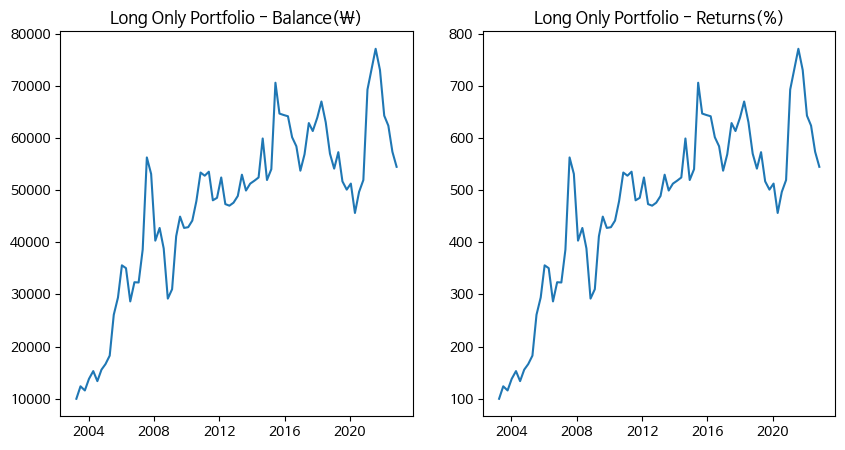

In [261]:
portfolio1.backtest()

C:\Users\kim56\AppData\Local\Temp\ipykernel_24352\3571813440.py:436: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs['Earnings'].loc[logs.index % 2 == 0] = np.NaN


,Ticker,Name,Date,Style,Strategy,Type,Price,Count,Weighted price,Earnings,Cum.Earnings,Returns(%)
0,005930,삼성전자,2004-04-12,Momentum,long,0,12200.0,0.031362,382.615411,NaN,NaN,NaN
1,005930,삼성전자,2004-07-13,Momentum,long,1,8670.0,0.031362,271.907837,-110.707574,-110.707574,-0.289344
2,005930,삼성전자,2004-07-13,Momentum,long,0,8670.0,0.038585,334.535917,-110.707574,-110.707574,-0.289344
3,005930,삼성전자,2004-10-13,Momentum,long,1,8980.0,0.038585,346.497409,11.961492,-98.746082,0.035755
4,005930,삼성전자,2005-10-17,Momentum,long,0,11260.0,0.068726,773.856549,11.961492,-98.746082,0.035755
5,005930,삼성전자,2006-01-13,Momentum,long,1,13880.0,0.068726,953.919085,180.062536,81.316454,0.232682
6,005930,삼성전자,2008-01-30,Momentum,long,0,11420.0,0.160425,1832.049840,180.062536,81.316454,0.232682
7,005930,삼성전자,2008-05-06,Momentum,long,1,14900.0,0.160425,2390.327724,558.277885,639.594339,0.304729
8,005930,삼성전자,2011-11-11,Momentum,long,0,19660.0,0.061690,1212.818392,558.277885,639.594339,0.304729
9,005930,삼성전자,2012-02-13,Momentum,long,1,21660.0,0.061690,1336.197680,123.379287,762.973626,0.101729


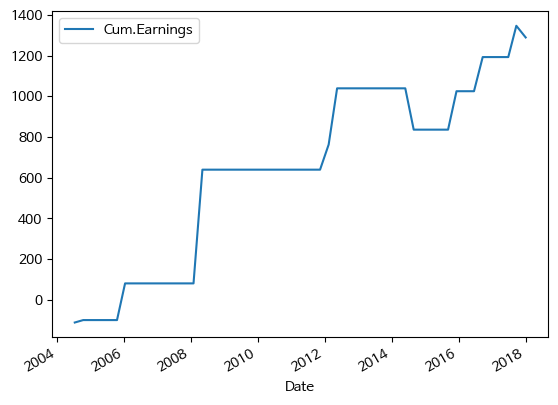

In [262]:
portfolio1.search_reports(name = '삼성전자')

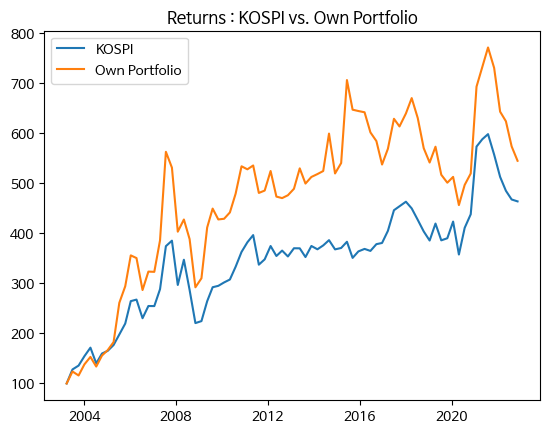

In [263]:
portfolio1.evaluate()

# Value Only Portfolio

### *Rebalancing Period : 3 months
### *Long only Quantile : 20%

In [264]:
portfolio2 = Portfolio(rebalancing_month=3, style = 'Value', strategy='long')
portfolio2.load_data(stock_data)
portfolio2.load_refer_data(refer_data)
portfolio2.load_benchmark(benchmark_data)
print(portfolio2.get_config())

The stock data is loaded.
The reference data is loaded.
The benchmark data is loaded.
{'rebalancing_month': 3, 'style': 'Value', 'strategy': 'long', 'value_weight': 1, 'momentum_weight': 0, 'init_money': 10000, 'quantile': 0.2}


	Balancing Accounts ... (2003-03-31)
[1/78] Constructing Portfolios ... (2003-03-31))
[10000]
 0.450 sec
	Balancing Accounts ... (2003-07-02)
[2/78] Constructing Portfolios ... (2003-07-02))
[10000, 14170.49970636536]
 0.517 sec
	Balancing Accounts ... (2003-10-07)
[3/78] Constructing Portfolios ... (2003-10-07))
[10000, 14170.49970636536, 14506.877195504623]
 0.604 sec
	Balancing Accounts ... (2004-01-07)
[4/78] Constructing Portfolios ... (2004-01-07))
[10000, 14170.49970636536, 14506.877195504623, 16861.04429910271]
 0.577 sec
	Balancing Accounts ... (2004-04-12)
[5/78] Constructing Portfolios ... (2004-04-12))
[10000, 14170.49970636536, 14506.877195504623, 16861.04429910271, 18399.122604424752]
 0.588 sec
	Balancing Accounts ... (2004-07-13)
[6/78] Constructing Portfolios ... (2004-07-13))
[14170.49970636536, 14506.877195504623, 16861.04429910271, 18399.122604424752, 16030.417727658183]
 0.496 sec
	Balancing Accounts ... (2004-10-13)
[7/78] Constructing Portfolios ... (2004-10-13))

[46718.233407427135, 48856.75354103859, 49344.74663980467, 48342.98946089663, 51391.304144291484]
 0.485 sec
	Balancing Accounts ... (2014-05-29)
[45/78] Constructing Portfolios ... (2014-05-29))
[48856.75354103859, 49344.74663980467, 48342.98946089663, 51391.304144291484, 53600.93971008648]
 0.508 sec
	Balancing Accounts ... (2014-08-29)
[46/78] Constructing Portfolios ... (2014-08-29))
[49344.74663980467, 48342.98946089663, 51391.304144291484, 53600.93971008648, 55069.47587362141]
 0.589 sec
	Balancing Accounts ... (2014-12-03)
[47/78] Constructing Portfolios ... (2014-12-03))
[48342.98946089663, 51391.304144291484, 53600.93971008648, 55069.47587362141, 50561.41472265904]
 0.500 sec
	Balancing Accounts ... (2015-03-10)
[48/78] Constructing Portfolios ... (2015-03-10))
[51391.304144291484, 53600.93971008648, 55069.47587362141, 50561.41472265904, 52179.7585798229]
 0.464 sec
	Balancing Accounts ... (2015-06-10)
[49/78] Constructing Portfolios ... (2015-06-10))
[53600.93971008648, 55069

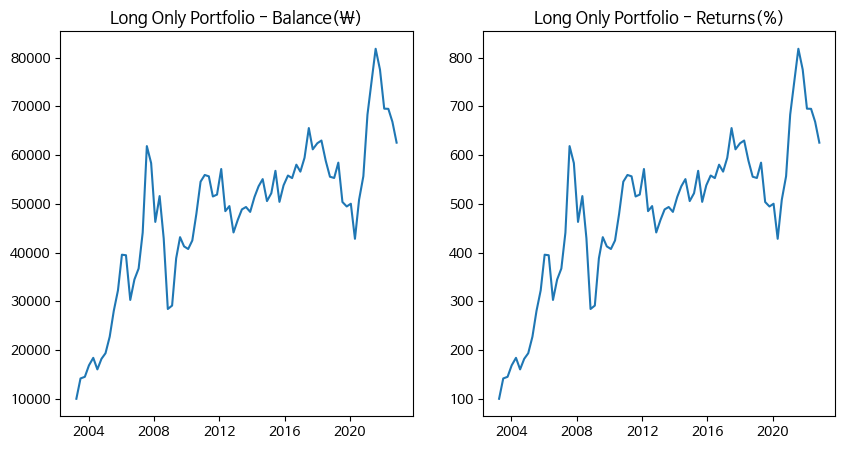

In [265]:
portfolio2.backtest()

C:\Users\kim56\AppData\Local\Temp\ipykernel_24352\3571813440.py:436: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs['Earnings'].loc[logs.index % 2 == 0] = np.NaN


,Ticker,Name,Date,Style,Strategy,Type,Price,Count,Weighted price,Earnings,Cum.Earnings,Returns(%)
0,005930,삼성전자,2014-08-29,Value,long,0,24680.0,0.055784,1376.736897,NaN,NaN,NaN
1,005930,삼성전자,2014-12-03,Value,long,1,25960.0,0.055784,1448.139783,71.402886,71.402886,0.051864
2,005930,삼성전자,2014-12-03,Value,long,0,25960.0,0.048692,1264.035368,71.402886,71.402886,0.051864
3,005930,삼성전자,2015-03-10,Value,long,1,28420.0,0.048692,1383.816840,119.781472,191.184358,0.094761
4,005930,삼성전자,2015-09-08,Value,long,0,22620.0,0.055700,1259.939113,119.781472,191.184358,0.094761
5,005930,삼성전자,2015-12-09,Value,long,1,25260.0,0.055700,1406.987710,147.048597,338.232955,0.116711


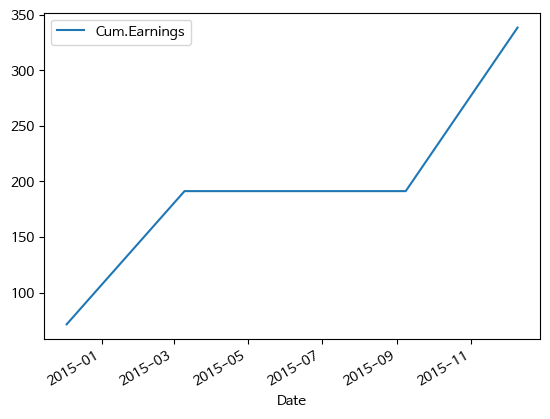

In [266]:
portfolio2.search_reports(name = '삼성전자')

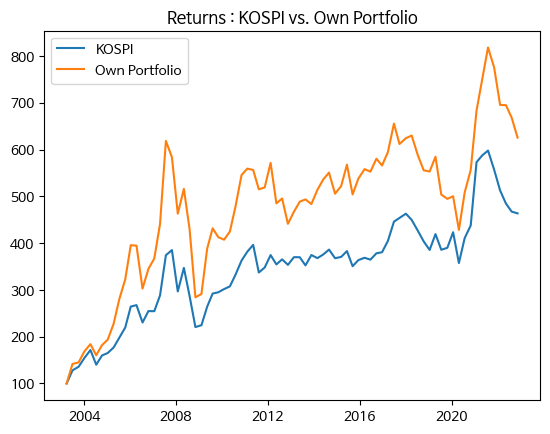

In [267]:
portfolio2.evaluate()

# Mixed Portfolio(Value + Momentum)

### *Rebalancing Period : 3 months
### *Long only Quantile : 20%
### *Weights : Momentum = 0.5, Value = 0.5

In [274]:
portfolio3 = Portfolio(style = 'Mixed', strategy='long', value_weight=0.5, momentum_weight=0.5, quantile=0.2)
portfolio3.load_data(stock_data)
portfolio3.load_refer_data(refer_data)
portfolio3.load_benchmark(benchmark_data)
portfolio3.get_config()

The stock data is loaded.
The reference data is loaded.
The benchmark data is loaded.


{'rebalancing_month': 3,
 'style': 'Mixed',
 'strategy': 'long',
 'value_weight': 0.5,
 'momentum_weight': 0.5,
 'init_money': 10000,
 'quantile': 0.2}

	Balancing Accounts ... (2003-03-31)
[1/78] Constructing Portfolios ... (2003-03-31))
[10000]
 0.784 sec
	Balancing Accounts ... (2003-07-02)
[2/78] Constructing Portfolios ... (2003-07-02))
[000060] is in bankruptcy
[000070] is in bankruptcy
[10000, 13277.00448359512]
 0.959 sec
	Balancing Accounts ... (2003-10-07)
[3/78] Constructing Portfolios ... (2003-10-07))
[10000, 13277.00448359512, 13009.274673688225]
 1.145 sec
	Balancing Accounts ... (2004-01-07)
[4/78] Constructing Portfolios ... (2004-01-07))
[10000, 13277.00448359512, 13009.274673688225, 15306.192609396552]
 1.004 sec
	Balancing Accounts ... (2004-04-12)
[5/78] Constructing Portfolios ... (2004-04-12))
[10000, 13277.00448359512, 13009.274673688225, 15306.192609396552, 16832.69278114397]
 1.032 sec
	Balancing Accounts ... (2004-07-13)
[6/78] Constructing Portfolios ... (2004-07-13))
[000070] is in bankruptcy
[13277.00448359512, 13009.274673688225, 15306.192609396552, 16832.69278114397, 14691.572515670574]
 1.024 sec
	Balan

[48223.984756195074, 51340.47846384016, 50124.53647106013, 50645.92108810438, 52526.73544893476]
 1.042 sec
	Balancing Accounts ... (2014-05-29)
[45/78] Constructing Portfolios ... (2014-05-29))
[51340.47846384016, 50124.53647106013, 50645.92108810438, 52526.73544893476, 53965.035145104535]
 1.135 sec
	Balancing Accounts ... (2014-08-29)
[46/78] Constructing Portfolios ... (2014-08-29))
[50124.53647106013, 50645.92108810438, 52526.73544893476, 53965.035145104535, 58550.694247399326]
 0.944 sec
	Balancing Accounts ... (2014-12-03)
[47/78] Constructing Portfolios ... (2014-12-03))
[50645.92108810438, 52526.73544893476, 53965.035145104535, 58550.694247399326, 52263.69875906226]
 0.974 sec
	Balancing Accounts ... (2015-03-10)
[48/78] Constructing Portfolios ... (2015-03-10))
[52526.73544893476, 53965.035145104535, 58550.694247399326, 52263.69875906226, 54145.469346713435]
 0.964 sec
	Balancing Accounts ... (2015-06-10)
[49/78] Constructing Portfolios ... (2015-06-10))
[53965.035145104535, 

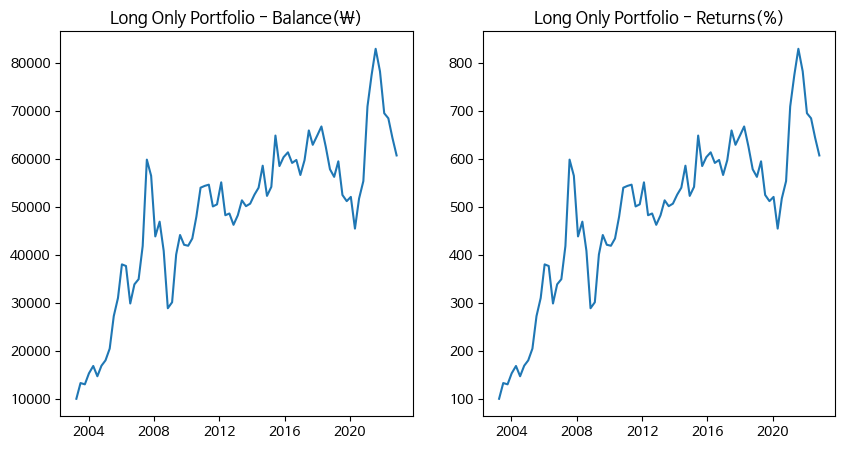

In [275]:
portfolio3.backtest()

C:\Users\kim56\AppData\Local\Temp\ipykernel_24352\3571813440.py:436: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs['Earnings'].loc[logs.index % 2 == 0] = np.NaN


,Ticker,Name,Date,Style,Strategy,Type,Price,Count,Weighted price,Earnings,Cum.Earnings,Returns(%)
0,005930,삼성전자,2004-04-12,Momentum,long,0,12200.0,0.017247,210.408660,NaN,NaN,NaN
1,005930,삼성전자,2004-07-13,Momentum,long,1,8670.0,0.017247,149.528121,-60.880538,-60.880538,-0.289344
2,005930,삼성전자,2004-07-13,Momentum,long,0,8670.0,0.021182,183.644656,-60.880538,-60.880538,-0.289344
3,005930,삼성전자,2004-10-13,Momentum,long,1,8980.0,0.021182,190.210959,6.566303,-54.314236,0.035755
4,005930,삼성전자,2005-10-17,Momentum,long,0,11260.0,0.034412,387.483049,6.566303,-54.314236,0.035755
5,005930,삼성전자,2006-01-13,Momentum,long,1,13880.0,0.034412,477.643403,90.160354,35.846118,0.232682
6,005930,삼성전자,2008-01-30,Momentum,long,0,11420.0,0.047961,547.720103,90.160354,35.846118,0.232682
7,005930,삼성전자,2008-05-06,Momentum,long,1,14900.0,0.047961,714.626053,166.905951,202.752069,0.304729
8,005930,삼성전자,2011-11-11,Momentum,long,0,19660.0,0.032108,631.252694,166.905951,202.752069,0.304729
9,005930,삼성전자,2012-02-13,Momentum,long,1,21660.0,0.032108,695.469652,64.216958,266.969027,0.101729


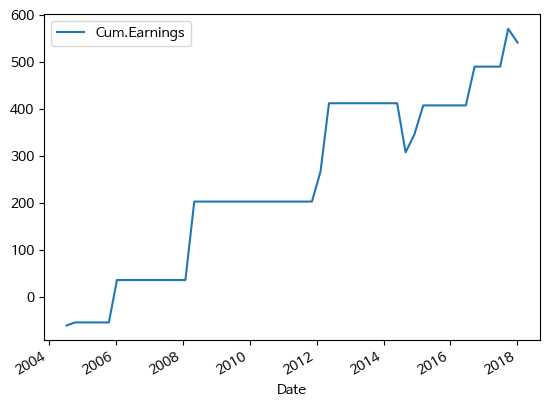

In [297]:
portfolio3.search_reports(name = '삼성전자')

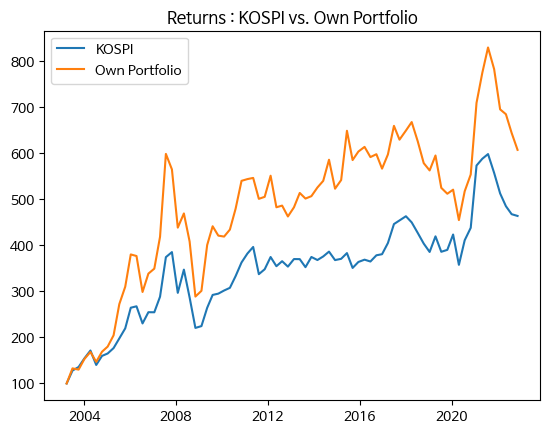

In [278]:
portfolio3.evaluate()

In [318]:
portfolio4 = Portfolio(style = 'Integrated', strategy='long', quantile=0.2)
portfolio4.load_data(stock_data)
portfolio4.load_refer_data(refer_data)
portfolio4.load_benchmark(benchmark_data)
portfolio4.get_config()

The stock data is loaded.
The reference data is loaded.
The benchmark data is loaded.


{'rebalancing_month': 3,
 'style': 'Integrated',
 'strategy': 'long',
 'value_weight': None,
 'momentum_weight': None,
 'init_money': 10000,
 'quantile': 0.2}

	Balancing Accounts ... (2003-03-31)
[1/78] Constructing Portfolios ... (2003-03-31))
[10000]
 0.398 sec
	Balancing Accounts ... (2003-07-02)
[2/78] Constructing Portfolios ... (2003-07-02))
[000060] is in bankruptcy
[000070] is in bankruptcy
[10000, 12338.760672171667]
 0.529 sec
	Balancing Accounts ... (2003-10-07)
[3/78] Constructing Portfolios ... (2003-10-07))
[10000, 12338.760672171667, 11722.562772843123]
 0.481 sec
	Balancing Accounts ... (2004-01-07)
[4/78] Constructing Portfolios ... (2004-01-07))
[10000, 12338.760672171667, 11722.562772843123, 14090.859802924913]
 0.504 sec
	Balancing Accounts ... (2004-04-12)
[5/78] Constructing Portfolios ... (2004-04-12))
[10000, 12338.760672171667, 11722.562772843123, 14090.859802924913, 15616.06790683026]
 0.550 sec
	Balancing Accounts ... (2004-07-13)
[6/78] Constructing Portfolios ... (2004-07-13))
[000070] is in bankruptcy
[12338.760672171667, 11722.562772843123, 14090.859802924913, 15616.06790683026, 13692.48941103177]
 0.502 sec
	B

[47943.00386752903, 51733.38263638695, 49215.55579236063, 51560.18904079098, 52147.34679552557]
 0.517 sec
	Balancing Accounts ... (2014-05-29)
[45/78] Constructing Portfolios ... (2014-05-29))
[51733.38263638695, 49215.55579236063, 51560.18904079098, 52147.34679552557, 52761.02656818196]
 0.508 sec
	Balancing Accounts ... (2014-08-29)
[46/78] Constructing Portfolios ... (2014-08-29))
[49215.55579236063, 51560.18904079098, 52147.34679552557, 52761.02656818196, 60036.04096055519]
 0.495 sec
	Balancing Accounts ... (2014-12-03)
[47/78] Constructing Portfolios ... (2014-12-03))
[51560.18904079098, 52147.34679552557, 52761.02656818196, 60036.04096055519, 52057.696787856265]
 0.553 sec
	Balancing Accounts ... (2015-03-10)
[48/78] Constructing Portfolios ... (2015-03-10))
[52147.34679552557, 52761.02656818196, 60036.04096055519, 52057.696787856265, 54140.16754730129]
 0.473 sec
	Balancing Accounts ... (2015-06-10)
[49/78] Constructing Portfolios ... (2015-06-10))
[52761.02656818196, 60036.04

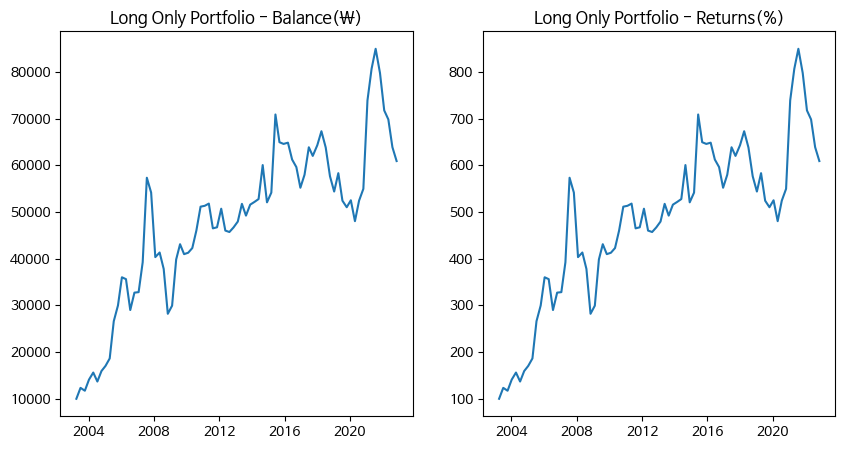

In [319]:
portfolio4.backtest()

C:\Users\kim56\AppData\Local\Temp\ipykernel_24352\4003959206.py:483: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs['Earnings'].loc[logs.index % 2 == 0] = np.NaN


,Ticker,Name,Date,Style,Strategy,Type,Price,Count,Weighted price,Earnings,Cum.Earnings,Returns(%)
0,005930,삼성전자,2004-04-12,Integrated,long,0,12200.0,0.032000,390.401698,NaN,NaN,NaN
1,005930,삼성전자,2004-07-13,Integrated,long,1,8670.0,0.032000,277.441206,-112.960491,-112.960491,-0.289344
2,005930,삼성전자,2004-07-13,Integrated,long,0,8670.0,0.039482,342.312235,-112.960491,-112.960491,-0.289344
3,005930,삼성전자,2004-10-13,Integrated,long,1,8980.0,0.039482,354.551773,12.239538,-100.720953,0.035755
4,005930,삼성전자,2005-10-17,Integrated,long,0,11260.0,0.066569,749.563508,12.239538,-100.720953,0.035755
5,005930,삼성전자,2006-01-13,Integrated,long,1,13880.0,0.066569,923.973490,174.409982,73.689028,0.232682
6,005930,삼성전자,2008-01-30,Integrated,long,0,11420.0,0.088285,1008.212548,174.409982,73.689028,0.232682
7,005930,삼성전자,2008-05-06,Integrated,long,1,14900.0,0.088285,1315.443692,307.231144,380.920172,0.304729
8,005930,삼성전자,2011-11-11,Integrated,long,0,19660.0,0.059402,1167.837925,307.231144,380.920172,0.304729
9,005930,삼성전자,2012-02-13,Integrated,long,1,21660.0,0.059402,1286.641376,118.803451,499.723623,0.101729


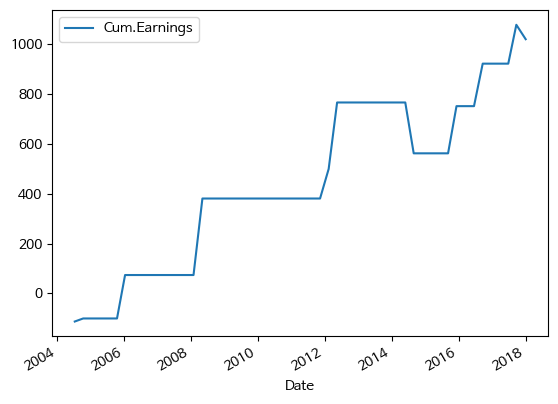

In [320]:
portfolio4.search_reports(name = '삼성전자')

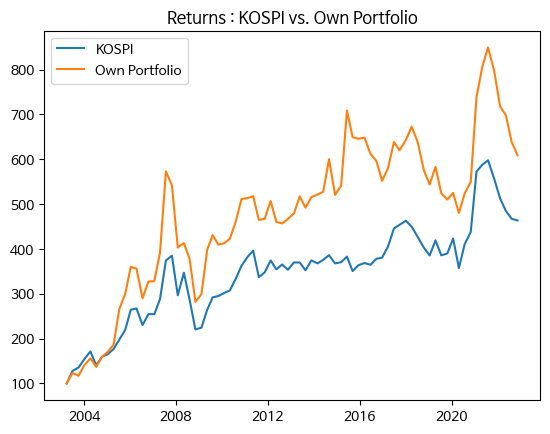

In [321]:
portfolio4.evaluate()

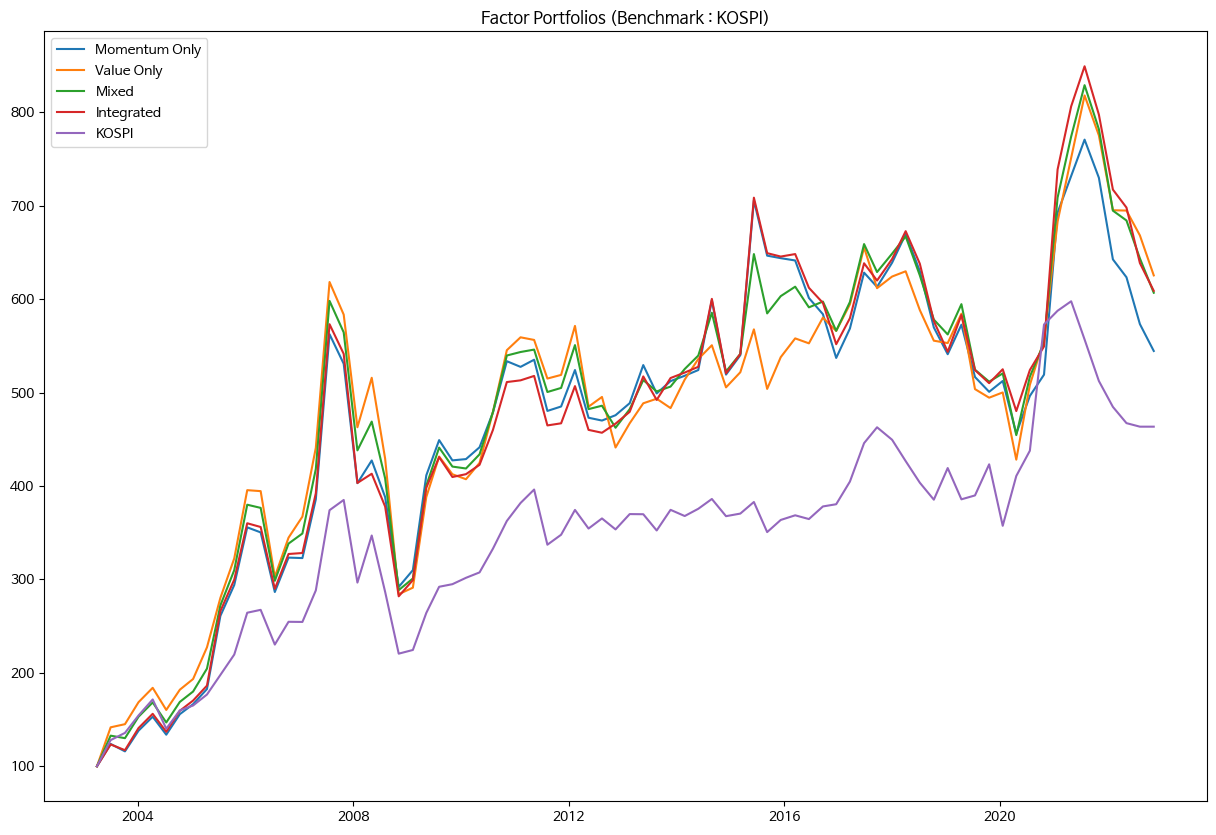

In [327]:
plt.figure(figsize = (15, 10))
df = pd.DataFrame({
    'Momentum Only' : portfolio1.results['Returns'],
    'Value Only' : portfolio2.results['Returns'], 
    'Mixed' : portfolio3.results['Returns'],
    'Integrated' : portfolio4.results['Returns'], 
    'KOSPI' : benchmark_data['Returns']
}).ffill()
dt = portfolio1.dt
df.index = dt
plt.plot(dt, df['Momentum Only'], dt, df['Value Only'],dt, df['Mixed'],dt, df['Integrated'], dt, df['KOSPI'])
plt.legend(df.columns)
plt.title('Factor Portfolios (Benchmark : KOSPI)')
plt.show()